<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Are-all-libraries-that-are-needed-available?" data-toc-modified-id="Are-all-libraries-that-are-needed-available?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Are all libraries that are needed available?</a></span></li><li><span><a href="#Prepare-an-image-provider-class" data-toc-modified-id="Prepare-an-image-provider-class-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare an image provider class</a></span></li><li><span><a href="#Build-a-Convolutional-Neural-Network-(CNN)" data-toc-modified-id="Build-a-Convolutional-Neural-Network-(CNN)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Build a Convolutional Neural Network (CNN)</a></span></li><li><span><a href="#Training-the-CNN" data-toc-modified-id="Training-the-CNN-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training the CNN</a></span></li></ul></div>

# Introduction

The goal of this notebook is to show you how to build a simple Convolutional Neural Network (CNN) for classification in Keras.

For this, first we need data! Search for open datasets of free images that show cars and bikes. E.g., Google has published the Open Image Dataset V4:

https://storage.googleapis.com/openimages/web/visualizer/index.htm

Prepare a folder data with the following structure:

    data
        train
            car
            bike
        test
            car
            bike
            
and store at least some
- hundreds-1000 of images for each object category in the training subfolders
- some hundreds of images for each object category in the test subfolders


# Are all libraries that are needed available?

In [55]:
import numpy as np
import tensorflow as tf
import keras
import cv2
import matplotlib
import matplotlib.pyplot as plt

print( "Your NumPy version is:      " + np.__version__ )
print( "Your TensorFlow version is: " + tf.__version__)
print( "Your Keras version is:      " + keras.__version__ )
print( "Your OpenCV version is:     " + cv2.__version__ )
print( "Your Matplotlib version is: " + matplotlib.__version__)

Your NumPy version is:      1.16.2
Your TensorFlow version is: 1.13.1
Your Keras version is:      2.2.4
Your OpenCV version is:     4.1.0
Your Matplotlib version is: 2.0.2


# Prepare an image provider class

We define a class ``image_provider`` that will give us a convenient access to the images.

Given a root folder (e.g. "C:\\data"), it automatically determines which subfolders are there (e.g. "C:\\data\\car" and "C:\\data\\bike"). Each subfolder is assumed to be one of the categories we are interested in (e.g. "car" and "bike").

An image provide object then stores a list of all training items:
    
        [filename1, class_id, class_name, teacher_vec]
        [filename2, class_id, class_name, teacher_vec]
        ...

In [56]:
import os
from os import listdir
from os.path import isdir, isfile, join

IMG_SIZE = (100,100)
    
class image_provider:
    
    #
    # Traverses all subfolders of the specified root_folder
    # and generates a list of the form:
    #
    # [ ["data/bikes/jfksdj43.jpg", "bikes",
    #   ["data/cars/bvcnm401.jpg", "cars"],
    #   ...
    # ]
    #
    def __init__(self, root_folder):
        
        self.all_training_items = []
       
        class_names = \
            [d for d in listdir(root_folder)
             if isdir(os.path.join(root_folder,d))]

        print("Under folder\n\t", root_folder,
              "\nI found the following subfolders/classes:")
        print(class_names)
        
        self.nr_classes = len(class_names)
        
        # For each subfolder ...
        for class_id, class_name in enumerate(class_names):
            
            subfolder_name = root_folder + "/" + class_name + "/"
            
            filenames = \
                [subfolder_name + f
                 for f in listdir(subfolder_name) if isfile(join(subfolder_name, f))]
            
            print("{} files in subfolder {}".format(len(filenames), subfolder_name) )
            
            # For each image filename in current subfolder ...
            for filename in filenames:
                
                teacher_vec = np.zeros( self.nr_classes )
                teacher_vec[class_id] = 1.0
                
                self.all_training_items.append(
                    [filename, class_id, class_name, teacher_vec] )              
        
        self.nr_images = len(self.all_training_items)
        print("There are {} images in total available.".format(self.nr_images))
        
        print("Here are the first 3 entries of the training items list generated:")
        print(self.all_training_items[:3])
        
    
    
    #   
    # Given an absolute filename,
    # load the image in using OpenCV,
    # then convert it to usual RGB color channel order
    # and scale values to be in range [0,1]
    #
    def load_image(self, absolute_filename):
        
        image = cv2.imread(absolute_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
        image = cv2.resize(image, IMG_SIZE, interpolation=cv2.INTER_AREA)
        image = image * (1.0 / 255.0)
        
        return image
        
        
       
    #
    # Return the image from the dataset
    # with the specified index
    #
    def get_specific_image(self, idx):
        
        image_filename  = self.all_training_items[idx][0]
        class_id        = self.all_training_items[idx][1]
        class_name      = self.all_training_items[idx][2]
        teacher_vec     = self.all_training_items[idx][3]
        
        image = self.load_image(image_filename)
        
        return image, class_id, class_name, teacher_vec
    
    
    #
    # Return an OpenCV image and the class label
    # where the image is chosen randomly from the
    # list of all images.
    #
    def get_random_image(self):
        
        rnd_idx = np.random.randint(0, self.nr_images)
        return self.get_specific_image( rnd_idx )

Let's test the image provider class:

In [57]:
train_folder = "V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\train"
my_image_provider = image_provider( train_folder )

Under folder
	 V:\01_job\12_datasets\01_imagenet_cars_vs_bikes\train 
I found the following subfolders/classes:
['bikes', 'cars']
1000 files in subfolder V:\01_job\12_datasets\01_imagenet_cars_vs_bikes\train/bikes/
1000 files in subfolder V:\01_job\12_datasets\01_imagenet_cars_vs_bikes\train/cars/
There are 2000 images in total available.
Here are the first 3 entries of the training items list generated:
[['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\train/bikes/0001.JPEG', 0, 'bikes', array([1., 0.])], ['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\train/bikes/0002.JPEG', 0, 'bikes', array([1., 0.])], ['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\train/bikes/0003.JPEG', 0, 'bikes', array([1., 0.])]]


Let us retrieve randomly one of the images and display it.

image has type <class 'numpy.ndarray'>
image has shape (100, 100, 3)
teacher vec: [1. 0.]


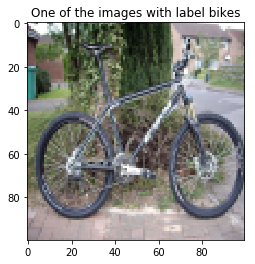

In [76]:
image, class_id, class_name, teacher_vec = \
    my_image_provider.get_random_image()
    
THE_INPUT_IMG_SHAPE = image.shape
    
print("image has type", type(image))
print("image has shape", image.shape)
print("teacher vec:", teacher_vec)
plt.imshow(image)
plt.title("One of the images with label {}".format(class_name))
plt.show()

# Build a Convolutional Neural Network (CNN)

Now we define a simple CNN in Keras.

What we need to specify is the input shape of a single image:

    (image_height, image_width, nr_color_channels)
    
Further, we need to specify how many output neurons the CNN shall have. This corresponds to the number of object classes we want to discriminate (classifiy) with the CNN:

    e.g., nr_output_neurons = 2 ("car" vs. "bike")
    e.g., nr_output_neurons = 3 ("car" vs. "bike" vs. "truck")
    
And then there are a lot of "hyperparameters" (model parameters we have to set manually):

- how many conv layers?
- how many pooling layers?
- order of layers?
- for each conv layer:
  - nr of filters?
  - kernel side length?
  - kernel stride?
  - activation function to use?
- for each max-pooling layer:
  - kernel side length?
  - kernel stride?
- for the final MLP at the end:
  - nr of layers?
  - for each MLP layer:
    - nr of neurons?
    - activation function to use?

In [77]:
from keras.utils import to_categorical
from keras import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
from keras import backend as K

def build_cnn_model(input_shape_of_single_image, nr_output_neurons):

    model = Sequential()

    # 1. Define the feature hierarchy:
    
    # Layer 1
    nr_filter       = 32
    kernel_side_len = 4
    kernel_stride   = 2
    model.add(Conv2D(nr_filter,
                     kernel_size=(kernel_side_len, kernel_side_len),
                     strides=(kernel_stride, kernel_stride),
                     activation='relu',
                     input_shape=input_shape_of_single_image)
             )
    
    # Layer 2
    kernel_side_len = 2
    kernel_stride   = 2
    model.add(MaxPooling2D(pool_size=(kernel_side_len, kernel_side_len),
                           strides=(kernel_stride, kernel_stride))
             )

    # 2. Define the MLP part:
    model.add(Flatten())
    model.add(Dense(nr_output_neurons, activation='softmax'))

    return model

# end build_a_cnn_model



# 1. Clear the last Keras session
#    This will clear the underlying TensorFlow graph
K.clear_session()


# 2. Create a CNN model
my_cnn = build_cnn_model(THE_INPUT_IMG_SHAPE, my_image_provider.nr_classes)


# 3. Show the model
my_cnn.summary()


# 4. Build model and configure model for training
my_cnn.compile(optimizer='adam', loss='categorical_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 49, 49, 32)        1568      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 36866     
Total params: 38,434
Trainable params: 38,434
Non-trainable params: 0
_________________________________________________________________


# Training the CNN

Now we will train the CNN. We will use "Stochastic Gradient Descent" (SGD) with just one training image per training step for the sake of simplicity (corresponds to mini batch with batch size 1). 

But note, that training could also be done using the "mini batch" approach. This means that in each training step we approximate the gradient for gradient descent step using e.g. 16,32,or 64 images.

This is normally much faster, however, it also means that we have to put all the images in one large 4D training array (img_nr, img_height, img_width, nr_channels). And this can make problems when we have a large dataset due to out-of-memory errors on the GPU or CPU being used.

In [78]:
nr_train_steps = 1000

height      = THE_INPUT_IMG_SHAPE[0]
width       = THE_INPUT_IMG_SHAPE[1]
nr_channels = THE_INPUT_IMG_SHAPE[2]

X = np.zeros( (1,height,width,nr_channels)     )
Y = np.zeros( (1,my_image_provider.nr_classes) )

for train_step in range(0,nr_train_steps):
    
    print("training step ", train_step)
    
    # 1. get the next random image from the dataset
    image, class_id, class_name, teacher_vec = \
        my_image_provider.get_random_image()
        
    # 2. put the image into a 4D array
    #    note: Keras expects a 4D array as input for
    #          the training function fit()
    X[0,:,:,:] = image
    
    # 3. the teacher value array expected by Keras
    #    is a 2D array
    Y[0,:] = teacher_vec
    
        
    # 3. train the model using this image    
    my_cnn.fit(X,Y)

training step  0
Epoch 1/1
1/1 [==============================] - 0s 147ms/step - loss: 0.6376
training step  1
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.1598
training step  2
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.0239
training step  3
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0055
training step  4
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 6.9974
training step  5
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 9.3778
training step  6
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 4.4051
training step  7
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0201
training step  8
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 4.7683
training step  9
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.3110
training step  10
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.1978
training step  88
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.1117
training step  89
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.1850
training step  90
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0676
training step  91
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0386
training step  92
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 3.3237
training step  93
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0444
training step  94
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.0374
training step  95
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0388
training step  96
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 3.2974
training step  97
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 2

training step  174
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.6225
training step  175
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.8249
training step  176
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.6845
training step  177
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.6821
training step  178
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.6945
training step  179
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.7187
training step  180
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.4768
training step  181
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.6363
training step  182
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.5050
training step  183
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.3136
training step  184
Epoch 1/1
1/1 [================

1/1 [==============================] - 0s 4ms/step - loss: 0.6940
training step  261
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.6577
training step  262
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.6868
training step  263
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.6465
training step  264
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.6727
training step  265
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.6965
training step  266
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.7220
training step  267
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.6712
training step  268
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.7553
training step  269
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3625
training step  270
Epoch 1/1
1/1 [==============================] - 0s 3ms/step

training step  347
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1.1643
training step  348
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.7030
training step  349
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.5798
training step  350
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 1.0018
training step  351
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.5598
training step  352
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.6040
training step  353
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.6042
training step  354
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.4379
training step  355
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3866
training step  356
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.0632
training step  357
Epoch 1/1
1/1 [================

training step  434
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.4028
training step  435
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.8364
training step  436
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3529
training step  437
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1.0145
training step  438
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.1095
training step  439
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.3733
training step  440
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.4223
training step  441
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.1782
training step  442
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1.1669
training step  443
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3363
training step  444
Epoch 1/1
1/1 [================

1/1 [==============================] - 0s 4ms/step - loss: 0.7253
training step  521
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.6397
training step  522
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.6161
training step  523
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.5851
training step  524
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3698
training step  525
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.4023
training step  526
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.2269
training step  527
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.1447
training step  528
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.5165
training step  529
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.7666
training step  530
Epoch 1/1
1/1 [==============================] - 0s 3ms/step

training step  607
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.6785
training step  608
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.6149
training step  609
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.0667
training step  610
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.1651
training step  611
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.5382
training step  612
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
training step  613
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.8507
training step  614
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.6055
training step  615
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.3028
training step  616
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.7587
training step  617
Epoch 1/1
1/1 [================

1/1 [==============================] - 0s 4ms/step - loss: 0.3929
training step  694
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0898
training step  695
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.3329
training step  696
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.4831
training step  697
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.4524
training step  698
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3062
training step  699
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.4322
training step  700
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.1016
training step  701
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1.1890
training step  702
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.1451
training step  703
Epoch 1/1
1/1 [==============================] - 0s 4ms/step

training step  780
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.1183
training step  781
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.4636
training step  782
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1.8238
training step  783
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.1391
training step  784
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.1395
training step  785
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.6413
training step  786
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0379
training step  787
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.1197
training step  788
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.2577
training step  789
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.1778
training step  790
Epoch 1/1
1/1 [================

1/1 [==============================] - 0s 4ms/step - loss: 1.1501
training step  867
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.4589
training step  868
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1.0548
training step  869
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.0768
training step  870
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 1.4269
training step  871
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0101
training step  872
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.5616
training step  873
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0295
training step  874
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.7181
training step  875
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.2992
training step  876
Epoch 1/1
1/1 [==============================] - 0s 4ms/step

training step  953
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1.4910
training step  954
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.0148
training step  955
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.5304
training step  956
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.0699
training step  957
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.1684
training step  958
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.4342
training step  959
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0603
training step  960
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3404
training step  961
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.4337
training step  962
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3966
training step  963
Epoch 1/1
1/1 [================